# Remote Sensing Advanced Methods - 2021


## So2Sat LCZ42

By 2050, Berlin summers could be as hot as in Canberra, Australia. Pankow, a district in the city’s north, has already declared a climate emergency in 2019 and is planning ahead. It is planting trees from the Mediterranean that can withstand the heat, and has calculated computer simulations for sunshine and cold air corridors for the construction of 1200 new apartments. A few changes, like swapping asphalt and concrete that store heat against greenery that soaks up water and provides shade, can make a difference on the local scale. Many of these changes on a local scale then make a difference on the bigger scale.

To understand local climate in cities, scientists have developed the Local Climate Zone classification scheme, as part of the So2Sat project. The aim is to create a 4D urban map of the world.

It differentiates between 17 zones based mainly on surface structures (such as building and tree density) as well as surface cover (green, pervious soils versus impervious grey surfaces). There are algorithms that calculate these maps from freely available satellite imagery, but there’s still room for improvement by adapting or developing suitable and advanced Convolutional Neural Network (CNN) architectures that generalise well.

The outcome of So2Sat will be the first and unique global and consistent spatial data set on urban morphology (3D/4D) of settlements, and a multidisciplinary application derivate assessing population density. This is seen as a giant leap for urban geography research as well as for formation of opinions for stakeholders based on resilient data.

```
@article{zhu2020so2sat,
  title={So2Sat LCZ42: a benchmark data set for the classification of global local climate zones [Software and Data Sets]},
  author={Zhu, Xiao Xiang and Hu, Jingliang and Qiu, Chunping and Shi, Yilei and Kang, Jian and Mou, Lichao and Bagheri, Hossein and Haberle, Matthias and Hua, Yuansheng and Huang, Rong and others},
  journal={IEEE Geoscience and Remote Sensing Magazine},
  volume={8},
  number={3},
  pages={76--89},
  year={2020},
  publisher={IEEE}
}
```  

## Table of Contents

1. [Meet the Data](#1.-Meet-the-Data)
2. [Simple Classification Baseline](#2.-Simple-Classification-Baseline)
3. [Random Initialization](#3.-Random-Initialization)
4. [Matrix Spaces](#4.-Matrix-Spaces)

In [ ]:
# uncomment to install the required packages
# import sys
# !{sys.executable} -m pip install -r requirements.txt

## 1. Meet the Data

First, load the required packages and the date Then, let us check how the data looks like.

In [1]:
import h5py
import numpy as np
import pyDOE

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

from scipy import stats

import collections

import tensorflow as tf

2022-02-10 14:18:39.615423: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-10 14:18:39.615442: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# this should match the name of the downloaded data set
filename = 'data/subset_lcz42_10k.h5'

dataset = h5py.File(filename, 'r')

# show the content names
print(list(dataset.keys()))

['label', 'sen1', 'sen2']


In [3]:
# load the labels
labels = np.array(dataset['label'])

# show the shape
print("Labels shape: " + str(labels.shape))

# print the labels
print(labels[0:10,:])

Labels shape: (10000, 17)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Sentinel-1 shape: (10000, 32, 32, 8)


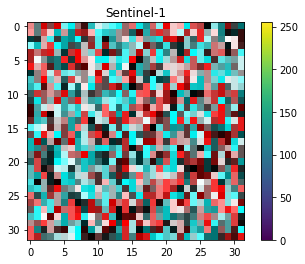

In [4]:
# load Sentinel-1 data
sen1 = np.array(dataset['sen1'])

print("Sentinel-1 shape: " + str(sen1.shape))

def false_color(X):
    """ False color visualization
    
    Sentinel-1 data in So2Sat LCZ42
        1) the real part of the unfiltered VH channel
        2) the imaginary part of the unfiltered VH channel
        3) the real part of the unfiltered VV channel
        4) the imaginary part of the unfiltered VV channel
        5) the intensity of the refined LEE filtered VH channel
        6) the intensity of the refined LEE filtered VV channel
        7) the real part of the refined LEE filtered covariance matrix off-diagonal element
        8) the imaginary part of the refined LEE filtered covariance matrix off-diagonal element
    """
    band1 = X[:,:,0]
    band2 = X[:,:,2]
    band3 = X[:,:,2]

    band1 = band1 / (band1.max()/255.0)
    band2 = band2 / (band2.max()/255.0)
    band3 = band3 / (band3.max()/255.0)

    tc = np.dstack((band1, band2, band3))
    
    return tc.astype('uint8')

# show one patch
# plt.imshow(10 * np.log10(sen1[10,:,:,0]), cmap=plt.cm.get_cmap('gray'))
plt.imshow(false_color(sen1[0,:,:,:]))
plt.colorbar()
plt.title('Sentinel-1')

plt.show()

Sentinel-2 shape: (10000, 32, 32, 10)


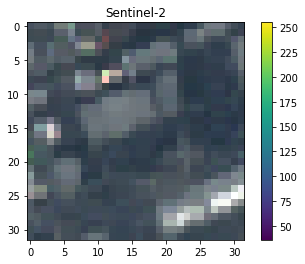

In [5]:
# load Sentinel-2 data
sen2 = np.array(dataset['sen2'])

print("Sentinel-2 shape: " + str(sen2.shape))

def true_color(X):
    """ Define True Color Sentinel image
    
    The function returns the MinMax scaled RGB bands
    
    Sentinel-2 Bands in So2Sat LCZ 42
        1) Band B2 (Blue), 10m GSD
        2) Band B3 (Green), 10m GSD
        3) Band B4 (Red), 10m GSD
        4) Band B5, upsampled to 10m from 20m GSD
        5) Band B6, upsampled to 10m from 20m GSD
        6) Band B7, upsampled to 10m from 20m GSD
        7) Band B8, 10m GSD
        8) Band B8a, upsampled to 10m from 20m GSD
        9) Band B11, upsampled to 10m from 20m GSD
        10) and Band B12, upsampled to 10m from 20m GSD

    Matplot convention RGB [0, 255]    
    """    
    blue = X[:,:,0] / (X[:,:,0].max()/255.0)
    green = X[:,:,1] / (X[:,:,1].max()/255.0)
    red = X[:,:,2] / (X[:,:,2].max()/255.0)
    
    tc = np.dstack((red, green, blue))     
    
    return tc.astype('uint8')

# show one patch
plt.imshow(true_color(sen2[10,:,:,:]))
plt.colorbar()
plt.title('Sentinel-2')

plt.show()


## 2. Simple Classification Baseline 

Let's define a baseline using a Random Forest Classifier and Sentinel-2 images

In [42]:
# The random forest expects a vector of features. Therefore,
# we concatenate all bands and pixels
number_samples = sen2.shape[0]
X = np.reshape(sen2, (number_samples, 32 * 32 * 10))

print("Post-processed Sentinel-2 data shape: ", X.shape)

# Let us split the data into train and test
TRAIN_SPLIT = int(number_samples * .5)

X_train = X[:TRAIN_SPLIT,:]
X_test = X[TRAIN_SPLIT:,:]

# The labels are one hot encoded, but the random forest requires
# the class number
y_train = np.argmax(labels[:TRAIN_SPLIT,:], axis=1)
y_test = np.argmax(labels[TRAIN_SPLIT:,:], axis=1)

Post-processed Sentinel-2 data shape:  (10000, 10240)


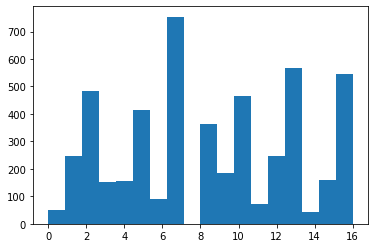

In [43]:
# TODO include histogram of labels
plt.hist(y_train, bins='auto')
plt.show()

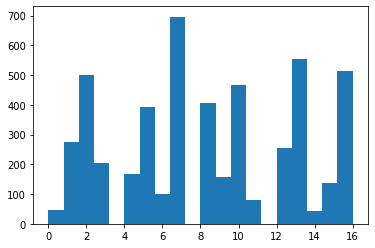

In [44]:
# TODO include histogram of labels
plt.hist(y_test, bins='auto')
plt.show()

In [45]:
# train a random forest classifier
def baseline_rf(
        X_train,
        y_train,
        X_test,
        y_test,        
        plot=False,
        random_state=0):
    """ Train a random forest classifier on the train data set, and evaluate
    its performance on the test data set.    
    """
    baseline_rf_classifier = RandomForestClassifier(random_state=random_state)
    baseline_rf_classifier.fit(X_train, y_train)
    y_pred_baseline_rf = baseline_rf_classifier.predict(X_test)
    acc_baseline_rf = accuracy_score(y_test, y_pred_baseline_rf)
    
    if plot:
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred_baseline_rf)
        plt.show()
    
    return acc_baseline_rf

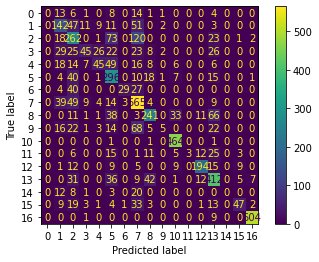

Accuracy Random Forest Classifier - Baseline (all training samples): 0.65080


In [46]:
acc_rf = baseline_rf(X_train, y_train, X_test, y_test, random_state=0, plot=True)

print("Accuracy Random Forest Classifier - Baseline (all training samples): {0:6.5f}".format(acc_rf))

In [14]:
accs_rf_bl = list()
for i in range(30):
    accs_rf_bl.append(baseline_rf(X_train, y_train, X_test, y_test, random_state=i))    
        
rf_bl_mean = np.mean(accs_rf_bl)
rf_bl_median = np.median(accs_rf_bl)
rf_bl_min = np.min(accs_rf_bl)
rf_bl_max = np.max(accs_rf_bl)
rf_bl_sd = np.std(accs_rf_bl)

print("Random Forest Classifier - Baseline")
print("mean: {0:6.5f}".format(rf_bl_mean))
print("median: {0:6.5f}".format(rf_bl_median))
print("min: {0:6.5f}".format(rf_bl_min))
print("max: {0:6.5f}".format(rf_bl_max))
print("sd: {0:6.5f}".format(rf_bl_sd))

Random Forest Classifier - Baseline
mean: 0.68280
median: 0.68275
min: 0.67200
max: 0.69500
sd: 0.00564


## 3. Random Initialization

In [47]:
# TODO adjust this number
INIT_SIZE = int(np.min([TRAIN_SPLIT * 0.1, 100]))

print("Initial sample size:", INIT_SIZE)

Initial sample size: 100


In [48]:
def random_init_eval(
        X_train,
        y_train,
        X_test,
        y_test,
        init_size,
        plot=False):
    """ Train a random forest classifier using a sub set of the train data set
    (of 'init_size' samples). The sub setting is done by randomly selecting 
    samples without replacement (i.e., no repeated samples). The evaluation of the
    performance is done on the test data set.
    """
    # randomly select 
    set_ix = np.random.choice(X_train.shape[0], size=INIT_SIZE, replace=False)    
    X_train_sample = X_train[set_ix]
    y_train_sample = y_train[set_ix]   
    
    acc_rf = baseline_rf(X_train_sample, y_train_sample, X_test, y_test, plot=plot)
        
    return acc_rf

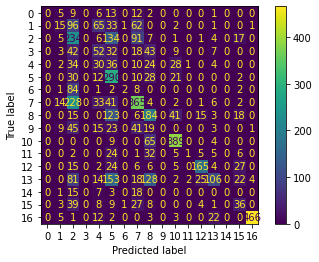

Accuracy Random Forest Classifier - Random Initialization: 0.45660


In [49]:
acc_rf = random_init_eval(X_train, y_train, X_test, y_test, INIT_SIZE, plot=True)
print("Accuracy Random Forest Classifier - Random Initialization: {0:6.5f}".format(acc_rf))

In [50]:
accs_rf_ri = list()
for i in range(30):
    accs_rf_ri.append(random_init_eval(X_train, y_train, X_test, y_test, INIT_SIZE))
    
rf_ri_mean = np.mean(accs_rf_ri)
rf_ri_median = np.median(accs_rf_ri)
rf_ri_min = np.min(accs_rf_ri)
rf_ri_max = np.max(accs_rf_ri)
rf_ri_sd = np.std(accs_rf_ri)

print("Random Forest Classifier - Random Initialization")
print("mean: {0:6.5f}".format(rf_ri_mean))
print("median: {0:6.5f}".format(rf_ri_median))
print("min: {0:6.5f}".format(rf_ri_min))
print("max: {0:6.5f}".format(rf_ri_max))
print("sd: {0:6.5f}".format(rf_ri_sd))

Random Forest Classifier - Random Initialization
mean: 0.45273
median: 0.45270
min: 0.40480
max: 0.50160
sd: 0.02095


In [51]:
# Check differences
print("Mean absolute difference:", np.abs(rf_ri_mean - rf_bl_mean))
stats.mannwhitneyu(accs_rf_bl, accs_rf_ri)

Mean absolute difference: 0.2300733333333333


MannwhitneyuResult(statistic=900.0, pvalue=3.000982378980083e-11)

## 4. Improved Sampling

Let's try to improve random sampling. We may consider several approaches, including clustering the samples, LHS, and grid search, among others. Also, the sampling may be performed on different data structures, e.g., the as-is data, gray-scaled, compressed/downsampled data, transformed, over extraced features, etc.

### 4.1. Clustering

In [25]:
def kmeans_eval(
        X_train,
        y_train,
        X_test,
        y_test,
        init_size,
        X_train_for_clustering,
        number_of_clusters=10,
        cluster_exclusion=False,
        plot=False):
    """ Train a random forest classifier using a sub set of the train data set
    (of 'init_size' samples). The sub setting is done by picking samples from the 
    clusters (k-means clustering with 'number_of_cluster' equal to 'number_of_clusters').
    Note that the clustering is performed on 'X_train_for_clustering' and not on 'X_train'. Thus,
    it is possible to try multiple data transformations for the clustering.
    The number of samples per cluster is proportional to the size of the cluster. 
    The evaluation of the performance is done on the test data set.
    """
    # TODO: the number of cluster should be adjusted using internal/external validation metrics
    kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(X_train_for_clustering)
    # we will use the number of elements per cluster to select the initial batch
    kmeans_counts = collections.Counter(kmeans.labels_)
    if plot:
        print("Number of elements per cluster:", dict(kmeans_counts))
    
    counts = list()
    for i in range(len(kmeans_counts)):
        counts.append(kmeans_counts[i])
        
    counts = np.array(counts)
    counts = counts / counts.min()
    counts = counts / counts.sum()
    counts = counts * init_size
    counts = counts.astype(int)
    if not cluster_exclusion:
        counts[counts == 0] = 1
    
    while counts.sum() != init_size:
        if counts.sum() > init_size:
            counts[counts.argmax()] = counts[counts.argmax()] - 1
        elif counts.sum() < init_size:
            counts[counts.argmin()] = counts[counts.argmin()] + 1
    
    # TODO get images from clusters
    set_ix = list()
    for i in range(len(counts)):
        pos = np.where(kmeans.labels_ == i)[0]
        set_ix = set_ix + np.random.choice(pos, size=counts[i], replace=False).tolist()    
        
    X_train_sample = X_train[set_ix]    
    y_train_sample = y_train[set_ix]   
    
    acc_rf = baseline_rf(X_train_sample, y_train_sample, X_test, y_test, plot=plot)
        
    return acc_rf

Sentinel-2 shape: (32, 32)


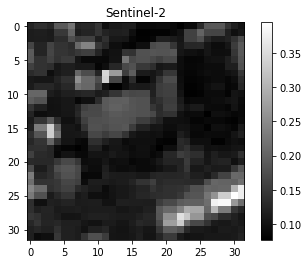

In [21]:
def to_grayscale(X):
    """ Define Grayscale Sentinel image
       
    Sentinel-2 Bands in So2Sat LCZ 42
        1) Band B2 (Blue), 10m GSD
        2) Band B3 (Green), 10m GSD
        3) Band B4 (Red), 10m GSD
        4) Band B5, upsampled to 10m from 20m GSD
        5) Band B6, upsampled to 10m from 20m GSD
        6) Band B7, upsampled to 10m from 20m GSD
        7) Band B8, 10m GSD
        8) Band B8a, upsampled to 10m from 20m GSD
        9) Band B11, upsampled to 10m from 20m GSD
        10) and Band B12, upsampled to 10m from 20m GSD
    """    
    blue = X[:,:,0] # / (X[:,:,0].max()/255.0)
    green = X[:,:,1] # / (X[:,:,1].max()/255.0)
    red = X[:,:,2] # / (X[:,:,2].max()/255.0)

    gray = 0.2989 * red + 0.5870 * green + 0.1140 * blue

    return gray


gray = to_grayscale(sen2[10,:,:,:])

print("Sentinel-2 shape: " + str(gray.shape))

plt.imshow(gray, cmap="gray")
plt.colorbar()
plt.title('Sentinel-2')
plt.show()

In [52]:
sen2_gray = None

for i in range(sen2.shape[0]):
    if sen2_gray is None:
        sen2_gray = to_grayscale(sen2[i,:,:,:])
    else:
        sen2_gray = np.dstack((sen2_gray, to_grayscale(sen2[i,:,:,:])))

sen2_gray = np.moveaxis(sen2_gray, -1, 0)
    
# we are going to min-max scale the data to [0,1]
_min = np.min(sen2_gray)
_max = np.max(sen2_gray)

sen2_gray = (sen2_gray - _min) / (_max - _min)

print("Sentinel-2 gray scale shape:", sen2_gray.shape)

# we need "points" (vectors) for the clustering
sen2_gray_flattened = np.reshape(sen2_gray, (number_samples, 32 * 32))

print("Sentinel-2 gray scale flattened shape:", sen2_gray_flattened.shape)

X_train_gray = sen2_gray_flattened[:TRAIN_SPLIT,:]

Sentinel-2 gray scale shape: (10000, 32, 32)
Sentinel-2 gray scale flattened shape: (10000, 1024)


Number of elements per cluster: {2: 483, 13: 822, 7: 16, 6: 723, 0: 812, 4: 205, 11: 824, 1: 481, 5: 479, 15: 11, 9: 33, 10: 15, 8: 12, 3: 69, 14: 11, 12: 4}


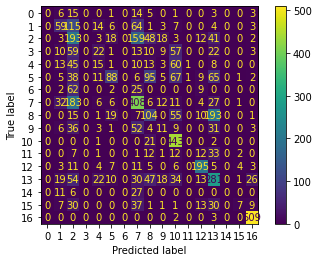

Accuracy Random Forest Classifier - k-Means Initialization: 0.46260


In [53]:
acc_rf = kmeans_eval(X_train, y_train, 
                     X_test, y_test, 
                     INIT_SIZE, X_train_gray,
                     cluster_exclusion=False,
                     number_of_clusters=16, plot=True)
print("Accuracy Random Forest Classifier - k-Means Initialization: {0:6.5f}".format(acc_rf))

In [54]:
NUMBER_OF_CLUSTERS = 16

accs_rf_km_ket = list()
for i in range(30):
    accs_rf_km_ket.append(
        kmeans_eval(X_train, y_train, 
                    X_test, y_test, 
                    INIT_SIZE, X_train_gray,
                    cluster_exclusion=True,
                    number_of_clusters=NUMBER_OF_CLUSTERS))
    
rf_km_ket_mean = np.mean(accs_rf_km_ket)
rf_km_ket_median = np.median(accs_rf_km_ket)
rf_km_ket_min = np.min(accs_rf_km_ket)
rf_km_ket_max = np.max(accs_rf_km_ket)
rf_km_ket_sd = np.std(accs_rf_km_ket)

print("Random Forest Classifier - k-Means Initialization (", NUMBER_OF_CLUSTERS, "clusters)")
print("mean: {0:6.5f}".format(rf_km_ket_mean))
print("median: {0:6.5f}".format(rf_km_ket_median))
print("min: {0:6.5f}".format(rf_km_ket_min))
print("max: {0:6.5f}".format(rf_km_ket_max))
print("sd: {0:6.5f}".format(rf_km_ket_sd))

Random Forest Classifier - k-Means Initialization ( 16 clusters)
mean: 0.45189
median: 0.45330
min: 0.41640
max: 0.49340
sd: 0.02062


In [55]:
# Check differences
print("Mean absolute difference (random init and k-means):", np.abs(rf_ri_mean - rf_km_ket_mean))
stats.mannwhitneyu(accs_rf_km_ket, accs_rf_ri)

Mean absolute difference (random init and k-means): 0.0008400000000000629


MannwhitneyuResult(statistic=426.5, pvalue=0.7338001548062383)

In [29]:
accs_rf_km_kef = list()
for i in range(30):
    accs_rf_km_kef.append(
        kmeans_eval(X_train, y_train, 
                    X_test, y_test, 
                    INIT_SIZE, X_train_gray,
                    cluster_exclusion=False,
                    number_of_clusters=NUMBER_OF_CLUSTERS))
    
rf_km_kef_mean = np.mean(accs_rf_km_kef)
rf_km_kef_median = np.median(accs_rf_km_kef)
rf_km_kef_min = np.min(accs_rf_km_kef)
rf_km_kef_max = np.max(accs_rf_km_kef)
rf_km_kef_sd = np.std(accs_rf_km_kef)

print("Random Forest Classifier - k-Means Initialization (", NUMBER_OF_CLUSTERS, "clusters)")
print("mean: {0:6.5f}".format(rf_km_kef_mean))
print("median: {0:6.5f}".format(rf_km_kef_median))
print("min: {0:6.5f}".format(rf_km_kef_min))
print("max: {0:6.5f}".format(rf_km_kef_max))
print("sd: {0:6.5f}".format(rf_km_kef_sd))

Random Forest Classifier - k-Means Initialization ( 16 clusters
mean: 0.41138
median: 0.41200
min: 0.34050
max: 0.46100
sd: 0.02461


In [32]:
# Check differences
print("Mean absolute difference (random init and k-means):", np.abs(rf_ri_mean - rf_km_kef_mean))
print(stats.mannwhitneyu(accs_rf_km_kef, accs_rf_ri))

print("Mean absolute difference (k-means with/out cluster exc):", np.abs(rf_km_kef_mean - rf_km_ket_mean))
print(stats.mannwhitneyu(accs_rf_km_ket, accs_rf_km_kef))

Mean absolute difference (random init and k-means): 0.008633333333333326
MannwhitneyuResult(statistic=547.5, pvalue=0.15147856754479208)
Mean absolute difference (k-means with/out cluster exc): 0.004766666666666641
MannwhitneyuResult(statistic=417.5, pvalue=0.6361125485531234)


### LHS



In [ ]:
init_design

In [ ]:
# we store the flattened matrices
sen2_gray_flattened = np.reshape(sen2_gray, (number_samples, 32 * 32))

def lhs_init_eval(
        X_train_set,
        y_train_set,
        init_size,
        lhs_space,
        plot=False):
    # init design
    init_design = pyDOE.lhs(lhs_space.shape[1], init_size)
    # given the initial points, we need to look for the closest samples
    # let's compute the Euclidean distances
    distances = None
    for i in range(init_size):
        dist = np.linalg.norm(sen2_gray_flattened - init_design[i,:], axis=1)
        if distances is None:
            distances = dist
        else:
            distances = np.dstack((distances, dist))
            
    distances = np.squeeze(distances)
    distances = np.moveaxis(distances, -1, 0)
    
    # let's get the closest sample
    # TODO continue here...
    np.min(distances, axis=1)        
    
    set_ix = None # TODO: populate this list
    
    X_train = X_train_set[set_ix]    
    y_train = y_train_set[set_ix]   
    
    # train a random forest classifier
    rf_classifier = RandomForestClassifier(random_state=0)
    rf_classifier.fit(X_train, y_train)
    y_pred_rf = rf_classifier.predict(X_test)
    acc_rf = accuracy_score(y_test, y_pred_rf)
    
    if plot:
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
        plt.show()
        
    return acc_rf

acc_rf = random_init_eval(X_train_set, y_train_set, INIT_SIZE, plot=True)
print("Accuracy Random Forest Classifier: ", acc_rf)
# pyDOE.lhs(2, samples=2)